In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
import numpy as np
import tensorflow as tf 
MANIFEST_DIR = "train.csv"
Batch_size = 8
Long = 886  #总数据样本数
Lens = 750  #划分的训练集样本数

#把标签转成oneHot
def convert2oneHot(index,Lens):
    hot = np.zeros((Lens,))
    hot[int(index)] = 1
    return(hot)

def xs_gen(path=MANIFEST_DIR,batch_size = Batch_size,train=True,Lens=Lens):

    img_list = pd.read_csv(path)
    if train:
        img_list = np.array(img_list)[:Lens]             #划分训练集，前Lens个数据为训练集
        print("Found %s train items."%len(img_list))
        print("list 1 is",img_list[0,-1])
        steps = math.ceil(len(img_list) / batch_size)    # 确定每轮有多少个batch
    else:
        img_list = np.array(img_list)[Lens:]             #划分验证集，Lens个数据后的数据为验证集
        print("Found %s test items."%len(img_list))
        print("list 1 is",img_list[0,-1])
        steps = math.ceil(len(img_list) / batch_size)    # 确定每轮有多少个batch
    while True:
        for i in range(steps):

            batch_list = img_list[i * batch_size : i * batch_size + batch_size]
            np.random.shuffle(batch_list)                #生成随机列表
            batch_x = np.array([file for file in batch_list[:,1:-1]])
            batch_y = np.array([convert2oneHot(label,5) for label in batch_list[:,-1]])
                                #因为是有10个故障类别，所以是(label,10)

            yield batch_x, batch_y                      #生成器，把yield简单看成return
#因为是有10个故障类别，所以是(label,10)

TEST_MANIFEST_DIR = "test_no_label.csv"

def ts_gen(path=TEST_MANIFEST_DIR,batch_size = Batch_size):

    img_list = pd.read_csv(path)

    img_list = np.array(img_list)[:Lens]
    print("Found %s train items."%len(img_list))
    print("list 1 is",img_list[0,-1])
    steps = math.ceil(len(img_list) / batch_size)    # 确定每轮有多少个batch
    while True:
        for i in range(steps):

            batch_list = img_list[i * batch_size : i * batch_size + batch_size]
            #np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:,1:]])     #这里也看着改一下，1：或2：
            #batch_y = np.array([convert2oneHot(label,10) for label in batch_list[:,-1]])

            yield batch_x

读取一条数据进行显示

Found 750 train items.
list 1 is 1.0
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
(20480,)


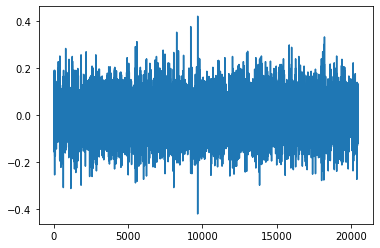

In [2]:
show_iter = xs_gen()
for x,y in show_iter:
    x1 = x[0]  #表示一个批次的第一个数据
    y1 = y[0]
    break
print(y)   #打印一个Batch_size = 20数据的 y 值，即故障类型的独热编码
print(x1.shape)
plt.plot(x1)
plt.show()

我们由上述信息可以看出每种导联都是由6000个点组成的列表，大家可以理解为mnist展开为一维后的形状

原始训练数据乱序操作

## 2.网络模型搭建
数据我们处理好了，后面就是模型的搭建了，我使用keras搭建的，操作简单便捷，tf，pytorch，sklearn大家可以按照自己喜好来。

网络模型可以选择CNN，RNN，Attention结构，或者多模型的融合，抛砖引玉，此Baseline采用的一维CNN方式

模型搭建

In [3]:
TIME_PERIODS = 20480   #因为数据有6000个按时间序列连续采样的振动信号数值
def build_model(input_shape=(TIME_PERIODS,),num_classes=5):  #分成 10 类，因为有10类故障
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, 1), input_shape=input_shape))
    model.add(Conv1D(16, 8,strides=2, activation='relu',input_shape=(TIME_PERIODS,1)))
    model.add(Conv1D(16, 8,strides=2, activation='relu',padding="same"))  #步长为 2,padding设置为输出、输入同大小
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 4,strides=2, activation='relu',padding="same"))
    model.add(Conv1D(64, 4,strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 4,strides=2, activation='relu',padding="same"))
    model.add(Conv1D(256, 4,strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(512, 2,strides=1, activation='relu',padding="same"))
    model.add(Conv1D(512, 2,strides=1, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return(model)

## 3. 网络模型训练
模型训练

In [9]:
Train = True
import datetime
import tensorflow as tf 
if __name__ == "__main__":
    if Train == True:
        train_iter = xs_gen()
        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True,verbose=1)
        
        log_dir = os.path.join('log')
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                    optimizer=opt, metrics=['accuracy'])
        print(model.summary())

        hist = model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens//Batch_size,
            epochs=20,
            initial_epoch=0,
            validation_data = val_iter,
            validation_steps = (Long - Lens)//Batch_size,
            callbacks=[tensorboard_callback]
            )
        model.save("finishModel.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 20480, 1)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 10237, 16)         144       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 5119, 16)          2064      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2559, 16)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1280, 64)          4160      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 640, 64)           16448     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 320, 64)          

ProfilerNotRunningError: Cannot stop profiling. No profiler is running.

## tensorboard 用法
```python
log_dir = os.path.join('log')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
```
主要参考了这两篇文章：

https://blog.csdn.net/dcrmg/article/details/83017118

https://mp.weixin.qq.com/s/tuUemntIjZAuvauVg3aYgg

在程序所在目录下打开CMD，输入：tensorboard --logdir=log

之后别关CMD，让其一直在运行；接着打开浏览器，输入CMD反馈的网址即可
